# Pip Install the necessary librairies

In [5]:
pip install --quiet tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --quiet tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --quiet ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --quiet boto3

Note: you may need to restart the kernel to use updated packages.


In [150]:
pip install --quiet tensorflowjs

Note: you may need to restart the kernel to use updated packages.


# Import the librairies

In [8]:
import os
import pandas as pd
import sys
import numpy as np

# Troubleshooting and visualisation
import IPython.display as ipd
from tensorflow import keras


import csv
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import os
from scipy.io import wavfile
from scipy import signal
import wave
import random as rn
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import math
import skimage
import pickle
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
from tqdm.notebook import trange, tqdm
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from time import sleep
from keras.models import load_model
import pickle
import tensorflowjs as tfjs
%matplotlib inline

# Processing the dataset

The Dataset used in this project was dowloaded from <a href="https://zenodo.org/record/4904800#.YelpXfjjJPY">here</a>. It's a large dataset containing multiples recordings of mosquito, background and audio voice. It's know under the name "HumBugDB: a large-scale acoustic mosquito dataset".


In [9]:
filename = "mosquitoes_dataset.csv"
path_to_file = "./Data/mosquitoes_dataset.csv"
audio_dir = "./Data/humbugdb_neurips_2021"
dataFile = pd.read_csv(os.path.join(os.path.pardir, 'Desktop','Data', filename))
dataFile.head()

,id,length,name,sample_rate,sound_type,species,gender,mic_type,location_type
0,201552,16.753610,#1002-1011.wav,44100,background,NaN,NaN,Telinga,cup
1,201553,2.799464,#1002-1011.wav,44100,background,NaN,NaN,Telinga,cup
2,201554,2.713106,#1002-1011.wav,44100,background,NaN,NaN,Telinga,cup
3,201555,3.051345,#1002-1011.wav,44100,background,NaN,NaN,Telinga,cup
4,201556,2.504406,#1002-1011.wav,44100,background,NaN,NaN,Telinga,cup


In [9]:
dataFile['sound_type'].value_counts()

mosquito      6795
background    1900
audio          600
Name: sound_type, dtype: int64

C:\Users\utilisateur\anaconda3\envs\keras_env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


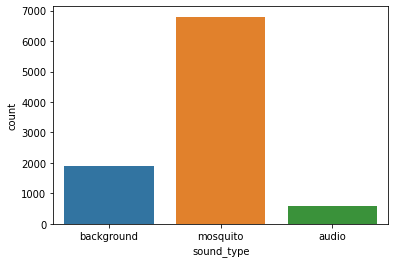

In [10]:
g = sns.countplot(dataFile['sound_type'])
g.set_xticklabels(['background','mosquito', 'audio'])
plt.show()

Total duration of mosquitoes: 65943.27143906523
Total duration of background: 52667.101998653015
Total duration of audios: 1845.9666470000025


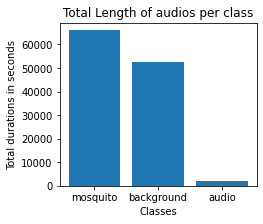

In [11]:
with open(path_to_file) as file:
    total_duration_mosquitoes = 0
    total_duration_background = 0
    total_duration_audios = 0
    for row in csv.reader(file):
        if(row[4]=="background"):
            total_duration_background += float(row[1])
        elif (row[4]=="mosquito"):
            total_duration_mosquitoes += float(row[1])
        elif (row[4]=="audio"):
            total_duration_audios += float(row[1])
    print("Total duration of mosquitoes: "+ str(total_duration_mosquitoes))
    print("Total duration of background: "+ str(total_duration_background))
    print("Total duration of audios: "+ str(total_duration_audios))
    names = ['mosquito', 'background', 'audio']
    values = [total_duration_mosquitoes, total_duration_background, total_duration_audios]
    plt.figure(figsize=(12, 3))
    plt.subplot(131)
    plt.bar(names, values)
    plt.ylabel('Total durations in seconds')
    plt.xlabel('Classes')
    plt.title('Total Length of audios per class')
    plt.show()

# Audio processing

In [11]:
sample_number = 2856
file_name= audio_dir + '/' + str(sample_number) +'.wav'
audio_data, sampling_rate = librosa.load(file_name)

In [14]:
#file_name= audio_dir +'/2856.wav'
def display_amplitude(audio_dir, sample_number):
    file_name= audio_dir + '/' + str(sample_number) +'.wav'
    audio_data, sampling_rate = librosa.load(file_name)
    librosa.display.waveplot(audio_data,sr=sampling_rate)
    
    plt.xlabel("Time (in seconds)")
    plt.ylabel("Amplitude")
    ipd.Audio(file_name)

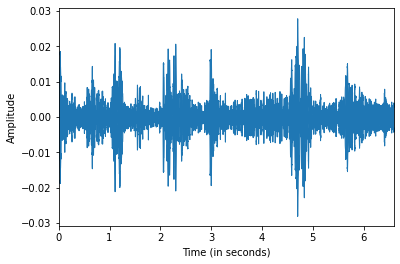

In [26]:
display_amplitude(audio_dir,sample_number)

In [18]:
def display_power_spectrum(audio_dir, sample_number):
    file_name= audio_dir + '/' + str(sample_number) +'.wav'
    audio_data, sampling_rate = librosa.load(file_name)
    signal, sample_rate = librosa.load(file_name, sr=sampling_rate)
    
    # FFT(Fast Fourier Transformation) -> power spectrum
    fft = np.fft.fft(signal)# calculate abs values on complex numbers to get magnitude
    spectrum = np.abs(fft)# create frequency variable
    f = np.linspace(0, sample_rate, len(spectrum))# take half of the spectrum and frequency as it is a mirror image
    half_spectrum = spectrum[:int(len(spectrum)/2)]
    half_f = f[:int(len(spectrum)/2)]# plot spectrum
    plt.figure(figsize=(5,2))
    plt.plot(half_f, half_spectrum, alpha=0.4)
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.title( 'Clip: ' + file_name )

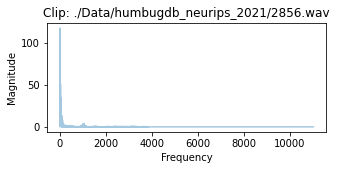

In [19]:
display_power_spectrum(audio_dir,sample_number)

In [20]:
def display_mfcc(audio_dir, sample_number, hop_length, n_fft):
    file_name= audio_dir + '/' + str(sample_number) +'.wav'
    audio_data, sampling_rate = librosa.load(file_name)
    signal, sample_rate = librosa.load(file_name, sr=sampling_rate)
    hop_length = 512 # in num. of samples
    n_fft = 1024 # window in num. of samples

    # extract 13 MFCCs
    MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
    
    #display MFCCs
    plt.figure(figsize=(5,3))
    librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("MFCC coefficients")
    plt.colorbar()
    plt.title('Clip: ' + file_name)
    
    # show the plot
    plt.show()

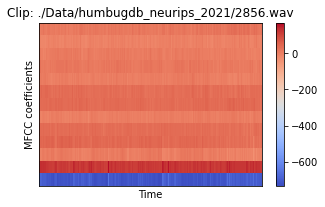

In [21]:
display_mfcc(audio_dir, sample_number, 512, 1024 )

In [22]:
def display_spect(audio_dir, sample_number):
    file_name= audio_dir + '/' + str(sample_number) +'.wav'
    audio_data, sampling_rate = librosa.load(file_name)
    signal, sample_rate = librosa.load(file_name, sr=sampling_rate)
    
    D = librosa.stft(signal)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    fig, ax = plt.subplots(figsize=(15,8))
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax, sr =sample_rate)
    ax.set(title= 'Clip: ' + file_name)
    
    # fig.colorbar(img, ax=ax, format="%+2.f dB")
    plt.show()
    display(ipd.Audio(signal, rate=sample_rate))

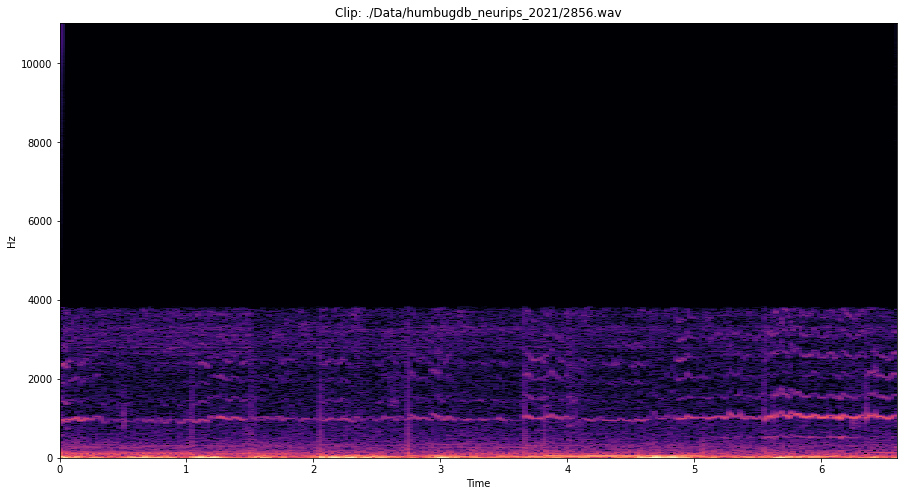

In [23]:
display_spect(audio_dir, sample_number)

In [27]:
print(audio_data)

[-0.00856975 -0.01207747 -0.0102553  ... -0.00168727 -0.00178377
  0.        ]


In [28]:
mfccs = librosa.feature.mfcc(y=audio_data, sr=sampling_rate, n_mfcc=40)
print(mfccs)

[[-576.2901    -594.5333    -610.53656   ... -630.9622    -630.8191
  -624.19904  ]
 [ 106.27939    121.897705   135.69655   ...  127.1376     125.82524
   114.81619  ]
 [  17.41399     -0.7757002  -14.531191  ...  -16.379665   -15.55345
    -3.891397 ]
 ...
 [   8.473456     8.929429     4.1727815 ...  -16.10771     -3.627471
     5.164253 ]
 [  -5.0839434   -9.6653385  -10.169769  ...    5.6836395   15.7651825
    13.090166 ]
 [  -4.231538   -12.314865   -13.586279  ...    9.253714     5.384987
    -5.5853167]]


# Extracting features

In order to train our model, and since we're aiming at performing audio classifcation. We are going to perform a feature extraction on all the recordings acailable in the Audio folder. 

In [39]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [40]:
extracted_features=[]
for index_num, row in tqdm(dataFile.iterrows()):
    _,file_format = os.path.splitext(row['name'])
    file_name = os.path.join(audio_dir, str(row['id']) + file_format)
    final_class_labels=row["sound_type"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

1297it [03:07,  7.43it/s]C:\Users\utilisateur\anaconda3\envs\keras_env\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=652
  n_fft, y.shape[-1]
1307it [03:08,  8.13it/s]C:\Users\utilisateur\anaconda3\envs\keras_env\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=108
  n_fft, y.shape[-1]
5823it [20:54, 31.21it/s]C:\Users\utilisateur\anaconda3\envs\keras_env\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1370
  n_fft, y.shape[-1]
5864it [20:55, 41.26it/s]C:\Users\utilisateur\anaconda3\envs\keras_env\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1773
  n_fft, y.shape[-1]
5869it [20:55, 42.03it/s]C:\Users\utilisateur\anaconda3\envs\keras_env\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input 

6211it [21:04, 45.65it/s]C:\Users\utilisateur\anaconda3\envs\keras_env\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1635
  n_fft, y.shape[-1]
6216it [21:04, 46.36it/s]C:\Users\utilisateur\anaconda3\envs\keras_env\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1114
  n_fft, y.shape[-1]
C:\Users\utilisateur\anaconda3\envs\keras_env\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1412
  n_fft, y.shape[-1]
6221it [21:04, 46.08it/s]C:\Users\utilisateur\anaconda3\envs\keras_env\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1263
  n_fft, y.shape[-1]
C:\Users\utilisateur\anaconda3\envs\keras_env\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1858
  n_fft, y.shape[-1]
6231i

Oour project is to classify sound and determine which is mosquito sound or not, so we have only kept the class we're interested in which is sound_type, and the features of each audio

In [41]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','sound_type'])
extracted_features_df.head(100)

,feature,sound_type
0,"[-472.6465, 117.656746, 0.2500602, 29.64109, 3...",background
1,"[-432.32993, 159.14757, -13.960641, 17.89705, ...",background
2,"[-432.96338, 167.28859, -1.2112825, 14.394361,...",background
3,"[-438.48682, 153.56854, -5.272339, 13.080124, ...",background
4,"[-434.0619, 156.59073, -7.0288663, 18.797493, ...",background
...,...,...
95,"[-445.39926, 162.38753, -15.154882, 9.1361, 22...",background
96,"[-453.50485, 176.5058, -20.979053, 7.52815, 21...",background
97,"[-436.0174, 170.4268, -17.61404, 11.571019, 25...",background
98,"[-413.06494, 166.53485, -20.213234, 3.4941146,...",background


Populating the x and y arrays

In [106]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['sound_type'].tolist())

In [107]:
X

array([[-4.72646515e+02,  1.17656746e+02,  2.50060201e-01, ...,
         3.16499233e+00,  4.27445126e+00,  2.61667562e+00],
       [-4.32329926e+02,  1.59147568e+02, -1.39606409e+01, ...,
         1.32700205e+00,  4.16455698e+00,  2.93404841e+00],
       [-4.32963379e+02,  1.67288589e+02, -1.21128249e+00, ...,
         1.24986875e+00,  3.83392596e+00,  3.08376503e+00],
       ...,
       [-5.55891846e+02,  1.27580269e+02,  1.45966253e+01, ...,
         3.16128802e+00,  4.46244001e+00, -1.96190262e+00],
       [-5.85014038e+02,  1.34209915e+02,  1.62215157e+01, ...,
         5.61812544e+00,  4.00681734e+00, -1.40105700e+00],
       [-5.11274963e+02,  9.18013763e+01,  2.76941991e+00, ...,
         8.74936342e-01,  6.44102395e-01,  2.86845922e-01]], dtype=float32)

In [108]:
print(X.shape)

(9295, 40)


In [109]:
y

array(['background', 'background', 'background', ..., 'mosquito',
       'mosquito', 'mosquito'], dtype='<U10')

In [110]:
print(y.shape)

(9295,)


In [111]:
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))
print(labelencoder.classes_)

['audio' 'background' 'mosquito']


Splitting the data into train and test arrays, we chose 20% of the data as test data.

In [56]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [113]:
num_labels=y.shape[1]

# Model

The classification model contains 4 layers, on the last layer we're using softmax so we can turn the probability vectors into classe vectors.

In [114]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

Compiling the model

In [115]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

We chose 100 epochs to train our model.

In [59]:
num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='./saved_models/mosquitoes_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
227/233 [============================>.] - ETA: 0s - loss: 11.4962 - accuracy: 0.6037WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001C30649A3A8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=1

233/233 [==============================] - 1s 4ms/step - loss: 0.1712 - accuracy: 0.9357 - val_loss: 0.1207 - val_accuracy: 0.9586
Epoch 21/100
229/233 [============================>.] - ETA: 0s - loss: 0.1707 - accuracy: 0.9402
Epoch 00021: val_loss improved from 0.12071 to 0.11447, saving model to ./saved_models\mosquitoes_classification.hdf5
233/233 [==============================] - 1s 3ms/step - loss: 0.1709 - accuracy: 0.9400 - val_loss: 0.1145 - val_accuracy: 0.9613
Epoch 22/100
218/233 [===========================>..] - ETA: 0s - loss: 0.1625 - accuracy: 0.9434
Epoch 00022: val_loss did not improve from 0.11447
233/233 [==============================] - 1s 3ms/step - loss: 0.1626 - accuracy: 0.9430 - val_loss: 0.1245 - val_accuracy: 0.9645
Epoch 23/100
221/233 [===========================>..] - ETA: 0s - loss: 0.1483 - accuracy: 0.9434
Epoch 00023: val_loss improved from 0.11447 to 0.11033, saving model to ./saved_models\mosquitoes_classification.hdf5
233/233 [=================

Epoch 48/100
220/233 [===========================>..] - ETA: 0s - loss: 0.1103 - accuracy: 0.9629
Epoch 00048: val_loss did not improve from 0.08896
233/233 [==============================] - 1s 3ms/step - loss: 0.1141 - accuracy: 0.9617 - val_loss: 0.1030 - val_accuracy: 0.9704
Epoch 49/100
221/233 [===========================>..] - ETA: 0s - loss: 0.1207 - accuracy: 0.9586
Epoch 00049: val_loss did not improve from 0.08896
233/233 [==============================] - 1s 3ms/step - loss: 0.1228 - accuracy: 0.9578 - val_loss: 0.0924 - val_accuracy: 0.9704
Epoch 50/100
223/233 [===========================>..] - ETA: 0s - loss: 0.1204 - accuracy: 0.9573
Epoch 00050: val_loss did not improve from 0.08896
233/233 [==============================] - 1s 3ms/step - loss: 0.1211 - accuracy: 0.9570 - val_loss: 0.1074 - val_accuracy: 0.9661
Epoch 51/100
229/233 [============================>.] - ETA: 0s - loss: 0.1081 - accuracy: 0.9600
Epoch 00051: val_loss did not improve from 0.08896
233/233 [==

Epoch 76/100
226/233 [============================>.] - ETA: 0s - loss: 0.1138 - accuracy: 0.9624
Epoch 00076: val_loss did not improve from 0.07551
233/233 [==============================] - 1s 4ms/step - loss: 0.1134 - accuracy: 0.9623 - val_loss: 0.1119 - val_accuracy: 0.9629
Epoch 77/100
220/233 [===========================>..] - ETA: 0s - loss: 0.1093 - accuracy: 0.9591
Epoch 00077: val_loss did not improve from 0.07551
233/233 [==============================] - 1s 4ms/step - loss: 0.1088 - accuracy: 0.9594 - val_loss: 0.0879 - val_accuracy: 0.9742
Epoch 78/100
224/233 [===========================>..] - ETA: 0s - loss: 0.1108 - accuracy: 0.9608
Epoch 00078: val_loss improved from 0.07551 to 0.07400, saving model to ./saved_models\mosquitoes_classification.hdf5
233/233 [==============================] - 1s 4ms/step - loss: 0.1091 - accuracy: 0.9614 - val_loss: 0.0740 - val_accuracy: 0.9779
Epoch 79/100
222/233 [===========================>..] - ETA: 0s - loss: 0.1034 - accuracy: 0.

Saving the model locally

In [60]:
#save the model to disk
model.save('./app/mosquito_classification_model.h5')

Loading the model to test if it was saved succesfully.

In [3]:
loaded_model = load_model('./mosquito_classification_model.h5')

In [4]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

Printing the loss and the accuracy of our Tests.

In [63]:
print(loaded_model.metrics_names)

['loss', 'accuracy']


In [64]:
test_accuracy=loaded_model.evaluate(X_test,y_test,verbose=0)
print('Test loss:',test_accuracy[0])
print('Test accuracy:', test_accuracy[1])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Test loss: 0.08338937908411026
Test accuracy: 0.9817106127738953


In [122]:
predict_x=model.predict(X_test) 
print(predict_x)
classes_x=np.argmax(predict_x,axis=1)
print(classes_x)

[[2.34454983e-05 4.66300705e-08 9.99976516e-01]
 [5.71655223e-12 1.23060186e-13 1.00000000e+00]
 [5.22274108e-12 1.42431535e-11 1.00000000e+00]
 ...
 [5.18785848e-10 1.97331405e-11 1.00000000e+00]
 [6.51641585e-08 3.86637111e-10 9.99999881e-01]
 [1.90931553e-13 1.20246813e-14 1.00000000e+00]]
[2 2 2 ... 2 2 2]


The fucntions predict the class of an audio recording and return it as output

In [15]:
def predict_class(audio_dir, sample_number):
    
    #####
    labelencoder=LabelEncoder()
    labelencoder.fit(["audio", "background", "mosquito"])
    ###
    
    filename=audio_dir+"/888.wav"
    audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
    print(sample_rate)
    duration =librosa.get_duration(y=audio, sr=sample_rate) 
    print(duration)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    print(mfccs_scaled_features)
    mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
    print(mfccs_scaled_features)
    print(mfccs_scaled_features.shape)
    predicted_label=loaded_model.predict(mfccs_scaled_features)
    print("Predicted Label: ")
    print(predicted_label)
    classes_x=np.argmax(predicted_label,axis=1)
    print("Classes X: ")
    print(classes_x)
    prediction_class = labelencoder.inverse_transform(classes_x)
    prediction_class
    print("Predicted Class: ")
    print(prediction_class)

In [16]:
predict_class(audio_dir, sample_number)

22050
9.081179138321996
[-558.5843      108.53366      36.464294     24.700018     11.283353
    2.9649634     6.1167994    15.077904     20.831251     14.837948
    3.4123044     3.6125865    10.907987     10.600003     12.678759
   15.601847      7.623771     -1.1296742     1.4225979     6.367768
   11.107459     18.245075     13.602394     -0.9335177    -9.170208
  -10.141608     -0.59499454   12.592925     11.999897      2.4173288
   -4.2954283    -2.0699902     3.8741126     3.743206     -1.2843566
   -6.449626     -3.9402418    -0.9013152    -7.7638726    -9.339905  ]
[[-558.5843      108.53366      36.464294     24.700018     11.283353
     2.9649634     6.1167994    15.077904     20.831251     14.837948
     3.4123044     3.6125865    10.907987     10.600003     12.678759
    15.601847      7.623771     -1.1296742     1.4225979     6.367768
    11.107459     18.245075     13.602394     -0.9335177    -9.170208
   -10.141608     -0.59499454   12.592925     11.999897      2.417328

In [71]:
def predict_class_return(audio_dir, sample_number):
    #####
    labelencoder=LabelEncoder()
    labelencoder.fit(["audio", "background", "mosquito"])
    ###
    filename= audio_dir +"/2856.wav"
    audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
    duration =librosa.get_duration(y=audio, sr=sample_rate) 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
    predicted_label=loaded_model.predict(mfccs_scaled_features)
    classes_x=np.argmax(predicted_label,axis=1)
    prediction_class = labelencoder.inverse_transform(classes_x)
    prediction_class
    return classes_x, predicted_label, prediction_class

In [125]:
classes_x, predicted_label, prediction_class= predict_class_return(audio_dir, sample_number)
print(classes_x)
print(predicted_label)
print(prediction_class)

[2]
[[9.0816833e-25 1.5113357e-05 9.9998486e-01]]
['mosquito']


# AWS Upload

Creating a S3 Bucket on AWS (Amazon Web Service)

In [25]:
import boto3

def create_bucket(region:str, bucket_name:str) -> dict:

    s3 = boto3.client('s3')
    response = s3.create_bucket(
        Bucket=bucket_name,
        CreateBucketConfiguration={
            'LocationConstraint':region
        }
    )
    return response

region = 'eu-west-3'
bucket_name = 'mosquitoes-classification-model-m2'
create_bucket(region, bucket_name)

{'ResponseMetadata': {'RequestId': 'AXN3CV4SFC2ZQAZF',
  'HostId': '6FfhcSFJvTL8UwuH+kM4jI+0BgmNVuDsYzh5QxBFyZV63CCMVuD0+Wx3n+MuWIVL8SnRicI+l3Q=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '6FfhcSFJvTL8UwuH+kM4jI+0BgmNVuDsYzh5QxBFyZV63CCMVuD0+Wx3n+MuWIVL8SnRicI+l3Q=',
   'x-amz-request-id': 'AXN3CV4SFC2ZQAZF',
   'date': 'Sat, 15 Jan 2022 23:20:09 GMT',
   'location': 'http://mosquitoes-classification-model-m2.s3.amazonaws.com/',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'Location': 'http://mosquitoes-classification-model-m2.s3.amazonaws.com/'}

Upload the model into the S3 bucket for further use.

In [142]:
from io import BytesIO
import joblib

def UploadModelToS3(data, bucket:str, key:str):
    
    with tempfile.TemporaryFile() as fp:
        joblib.dump(data, fp)
        fp.seek(0)
        s3_resource.put_object(Body=fp.read(), Bucket=bucket_name, Key=key)

    
bucket_name = 'mosquitoes-classification-model-m2'
key =  'models/mosquito_classification_model.h5'
UploadToS3(model, bucket_name, key)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity t

NotFoundError: 

List the objects present in the S3 bucket

In [147]:
def listS3Objects(bucket:str) -> list:

     # Connect to s3 resource
    s3 = boto3.resource('s3')
    my_bucket = s3.Bucket(bucket)

    # List all object keys in s3 bucket
    obj_list = [object_summary.key for object_summary in my_bucket.objects.all()]
    return obj_list

listS3Objects(bucket_name)

['validation/X_test.joblib']